# JHU covid-19 analysis
See daily increase of cases and deaths per US state.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import glob
import os
import matplotlib.ticker as mticker
import matplotlib.dates as mdates 
from datetime import timedelta
import datetime
import pytz
from tzwhere import tzwhere
import JHUprocessing as jp
from matplotlib.dates import date2num       #-->Update 
import matplotlib.dates as dt

  
# from figure_settings import *

# general parameters 

In [2]:
full_w = (12,7)
half_w = (6,4)

# load daily reports 

In [3]:
path = r'D:\Code_projects\Covid19_analysis\COVID-19\csse_covid_19_data\csse_covid_19_daily_reports'

daily_reports = glob.glob(path + '\*.csv') 
df = pd.DataFrame()
for file in daily_reports :
    df_temp = pd.read_csv( file, index_col=None, header=0)  
    
    if  '03-13-2020' in file :
        # correct for mistake in JHU data set
        df_temp['Last Update'] = pd.to_datetime(df_temp['Last Update']   )
        df_temp['Last Update'] = df_temp['Last Update'] + timedelta(days=2) 
        
         
    if  '03-09-2020' in file : 
        # correct for mistake in JHU data set
        df_temp['Last Update'] = pd.to_datetime(df_temp['Last Update']   )
        df_temp['Last Update'] = df_temp['Last Update'] + timedelta(days=1) 
        
#         bool_WA = df_temp['Province/State'].str.contains('CA',na=False) 
         
    df = df.append(df_temp, sort=True)  

# adjust column names and select relevant ones

In [4]:
  
# convert both separately 
df['Last Update'] = pd.to_datetime(df['Last Update']   )
df['Last_Update'] = pd.to_datetime(df['Last_Update']   )   # 
cond = df['Last_Update'].isnull()
df['Last Update'] = df['Last Update'].where(cond, df['Last_Update'] ) 
df['Datetime'] = pd.to_datetime(df['Last Update'] , unit='D'   ) 

### optional: convert times to pacific time 
df['Date'] = df['Datetime'].dt.date 

 
# compensate country/region
df['Country/Region'].isnull().sum() 
cond = df['Country_Region'].isnull()
df['Country/Region'] = df['Country/Region'].where(cond, df['Country_Region'] ) 

# province state
cond = df['Province_State'].isnull()
df['Province/State'] = df['Province/State'].where(cond, df['Province_State'] ) 
 
 
col_order = ['Date','Country/Region','Province/State','Active','Confirmed','Deaths','Recovered' ]
df = df[col_order]

df.tail()

,Date,Country/Region,Province/State,Active,Confirmed,Deaths,Recovered
2759,2020-04-05,West Bank and Gaza,NaN,211.0,237.0,1.0,25.0
2760,2020-04-05,Western Sahara,NaN,4.0,4.0,0.0,0.0
2761,2020-04-05,Zambia,NaN,35.0,39.0,1.0,3.0
2762,2020-04-05,Zimbabwe,NaN,8.0,9.0,1.0,0.0
2763,2020-04-05,US,Wyoming,0.0,0.0,0.0,0.0


# create US only frame

In [5]:
bool_US = df['Country/Region'] =='US'
df_US = df[bool_US ]
df_US.head() # .groupby('Date (UTC)').sum().tail(15)

,Date,Country/Region,Province/State,Active,Confirmed,Deaths,Recovered
31,2020-01-22,US,Washington,NaN,1.0,NaN,NaN
31,2020-01-23,US,Washington,NaN,1.0,NaN,NaN
33,2020-01-24,US,Washington,NaN,1.0,NaN,NaN
34,2020-01-24,US,Chicago,NaN,1.0,NaN,NaN
33,2020-01-25,US,Washington,NaN,1.0,NaN,NaN


# Create state entry

In [6]:
error_dict = {'Chicago':'Illinois',
            'NE (From Diamond Princess)':'Other',
            'CA (From Diamond Princess)':'Other',
            'TX (From Diamond Princess)':'Other',
            'Unassigned Location (From Diamond Princess)':'Other',
            'D.C.':'District of Columbia',
            'Puerto Rico':'Other',
            'Guam':'Other',
            'U.S.':'Other',
            'US':'Other',
            'Virgin Islands':'Other',
            'United States Virgin Islands':'Other',
            'Wuhan Evacuee':'Other',
            'American Samoa':'Other',
            'Northern Mariana Islands':'Other',
#             'Northern Mariana Islands':'Other',
            'OR ':'Oregon'}  

def replace_state( x):
    state_entry = x['Province/State'].split(", ")[-1] 
    if state_entry in jp.state_dict.keys(): 
        new = jp.state_dict[ state_entry]  
    elif state_entry in error_dict.keys():
        new = error_dict[state_entry]  
    else:
        new = state_entry   
    return new 
         
df_US.loc[:,'State'] = df_US.apply(replace_state, axis=1) 
 
### check washington frame
# bool_washington = df_US['Province/State'].str.contains('WA')
# df_US[bool_washington].groupby('Date').sum() 
# df_US[bool_washington] 

D:\D_program_files\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
D:\D_program_files\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


# Create df_state

In [7]:
df_state =  df_US.groupby(['State','Date']).sum().reset_index()
  
df_state = df_state.sort_values(by=['State','Date'], ascending=True )  
df_state.head() 

,State,Date,Active,Confirmed,Deaths,Recovered
0,Alabama,2020-03-13,0.0,5.0,0.0,0.0
1,Alabama,2020-03-14,0.0,6.0,0.0,0.0
2,Alabama,2020-03-15,0.0,12.0,0.0,0.0
3,Alabama,2020-03-16,0.0,29.0,0.0,0.0
4,Alabama,2020-03-17,0.0,39.0,0.0,0.0


# drop some "states"

In [8]:

bool_other = df_state['State'].str.contains( 'Other' , regex=False)

print('df_US shape: ' , df_state.shape)
df_state.drop( df_state[bool_other].index, inplace=True) 
print('df_US shape: ' , df_state.shape)



bool_other = df_state['State'].str.contains( 'Princess' , regex=False)

print('df_US shape: ' , df_state.shape)
df_state.drop( df_state[bool_other].index, inplace=True) 
print('df_US shape: ' , df_state.shape)

df_US shape:  (1561, 6)
df_US shape:  (1531, 6)
df_US shape:  (1531, 6)
df_US shape:  (1489, 6)


# adjust california

In [9]:
bool_cal = df_state['State'] == 'California'
bool_prior = df_state['Date'] < datetime.datetime(2020,2,10).date()
 

df_state.loc[bool_cal & bool_prior,'Confirmed'] = 0 

# find day 0

In [10]:
 # set thresholds for day 0 
threshold_cases = 1e2
threshold_deaths = 10


last_day = df_state['Date'].max()
bool_last = df_state['Date'] == last_day
df_state.loc[bool_last,'Confirmed']  > threshold_cases 
states = df_state['State'].unique() 
threshold_states = []

for state in states: 
    bool_state = df_state['State'] == state  
    df_temp = df_state[bool_state].copy()
    
    bool_threshold_cases = df_temp['Confirmed'] >= threshold_cases
    if bool_threshold_cases.sum() > 0: 
        day0 = df_temp.loc[bool_threshold_cases,'Date'].iloc[0]
        threshold_states.append(state) 
    else: 
        day0 = last_day + timedelta(days=1) 

    newdays = (df_temp['Date'] - day0).dt.days  
    
    df_state.loc[bool_state,'Delta C'] = newdays
     
    
    bool_threshold_death = df_temp['Deaths'] >= threshold_deaths
    if bool_threshold_death.sum() > 0:
        day0 = df_temp['Date'][bool_threshold_death].iloc[0]
    else:
        day0 = last_day + timedelta(days=1) 
        
    newdays = (df_temp['Date'] - day0).dt.days 
    df_state.loc[bool_state,'Delta D'] = newdays 

    
df_state.head()

,State,Date,Active,Confirmed,Deaths,Recovered,Delta C,Delta D
0,Alabama,2020-03-13,0.0,5.0,0.0,0.0,-8.0,-16.0
1,Alabama,2020-03-14,0.0,6.0,0.0,0.0,-7.0,-15.0
2,Alabama,2020-03-15,0.0,12.0,0.0,0.0,-6.0,-14.0
3,Alabama,2020-03-16,0.0,29.0,0.0,0.0,-5.0,-13.0
4,Alabama,2020-03-17,0.0,39.0,0.0,0.0,-4.0,-12.0


Text(0, 0.5, 'Confirmed cases')

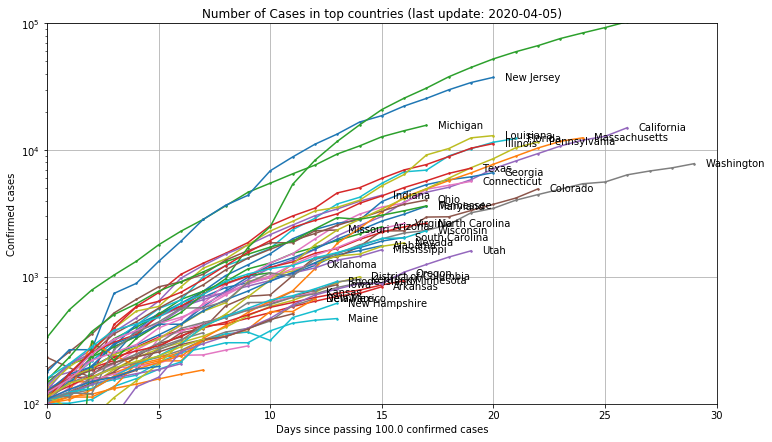

In [11]:
fig, ax = plt.subplots(1,1 ,figsize=full_w )

# states = df_state['State'].unique()
for state in threshold_states:
    bool_state = df_state['State'] == state 
    df_pl = df_state[bool_state] 
    ax.plot( df_pl['Delta C' ],  df_pl['Confirmed'],'.-' ,ms=3,lw=1.5, label=state )
     
    y = df_pl['Confirmed'].iloc[-1]*0.95
    x = df_pl['Delta C'].iloc[-1] + 0.5
    if x > 12:
        ax.annotate( state ,[x,y])
    
ax.set_yscale('log') 
ax.grid(True,which="major", linestyle='-')  
ax.set_title('Number of Cases in top countries (last update: ' + str( df_pl['Date'].iloc[-1]) + ')' ) 
ax.set_xlim([0,70])

ax.set_xlim([0,30])
ax.set_ylim([100,1e5])

ax.set_xlabel("Days since passing " + str(threshold_cases) + " confirmed cases") 
ax.set_ylabel("Confirmed cases") 


Text(0, 0.5, 'Confirmed deatjs')

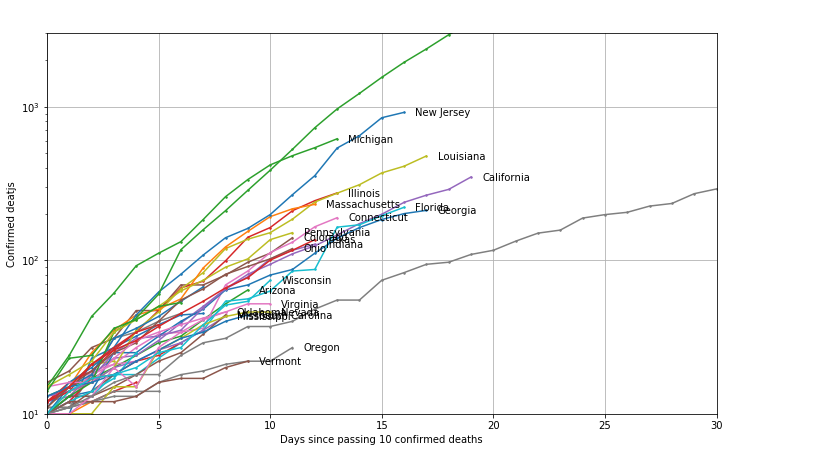

In [12]:
fig, ax = plt.subplots(1,1 ,figsize=full_w )

# states = df_state['State'].unique()
for state in threshold_states:
    bool_state = df_state['State'] == state 
    df_pl = df_state[bool_state] 
    ax.plot( df_pl['Delta D' ],  df_pl['Deaths'],'.-' ,ms=3,lw=1.5, label=state )
     
    y = df_pl['Deaths'].iloc[-1]*0.95
    x = df_pl['Delta D'].iloc[-1] + 0.5
    if x > 8:
        ax.annotate( state ,[x,y])
    
ax.set_yscale('log') 
ax.grid(True,which="major", linestyle='-')  
# ax.set_title('Number of Cases in top countries (last update: ' + str( df_pl['Date'].iloc[-1]) + ')' ) 
# ax.set_xlim([0,70])

ax.set_xlim([0,30])
ax.set_ylim([10,3e3])

# ax.set_xlabel("Days since passing 100 confirmed cases") 
ax.set_xlabel("Days since passing " + str(threshold_deaths) + " confirmed deaths") 
ax.set_ylabel("Confirmed deatjs") 

# add measures to dataframe 

In [13]:
# df_state = df_state.drop( columns=['Measure', 'Measures'])
df_m = pd.read_csv( "measures_per_state.csv", index_col=None ) 
df_m['Date'] = pd.to_datetime( df_m['Date'] ).dt.date 

# add measures to additional column
for i,row in df_m.iterrows(): 
    state = row['State']
    date = row['Date']
    bool_loc = (df_state['State'] == state) & (df_state['Date'] == date) 
    df_state.loc[bool_loc,'Measure'] = row['Measure']
df_m.head()
df_m

,State,Date,Measure
0,Alabama,2020-03-18,Schools closed
1,Alabama,2020-03-24,Shelter in place
2,Alaska,2020-03-28,Stay at home
3,Arizona,2020-03-31,Stay at home
4,California,2020-03-16,Local lockdown
5,California,2020-03-19,Stay at home
6,Colorado,2020-03-26,Stay at home
7,Conneticut,2020-03-23,Stay at home
8,Delaware,2020-03-24,Shelter in place
9,District of Columbia,2020-04-01,Stay at home


# add missing dates

In [14]:
# df_state = df_state.copy()

dates_unique =   df_state['Date'].unique()
dates = df['Date'].unique()
state_list =  df_state['State'].unique()  
 

# # find missing dates 
for state in state_list:
#     bool_state = df_state['State'] == state 
    for date in dates:
        bool_state = df_state['State'] == state 
        subframe = df_state.loc[bool_state,'Date'].tolist() 
        if date not in subframe : 
            append_series = pd.Series({'State':state,'Date':date,'Active':0,'Confirmed':0,'Deaths':0,'Recovered':0})
            df_state = df_state.append( append_series, ignore_index=True)
  
# subframe
bool_state = df_state['State'] == 'Alabama'
df_state[bool_state].sort_values(by=['Date'])
 
    
df_state = df_state.sort_values( by=['State','Date']).reset_index(drop=True) 
# datetime.datetim  
df_state.head()

,State,Date,Active,Confirmed,Deaths,Recovered,Delta C,Delta D,Measure
0,Alabama,2020-01-22,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1,Alabama,2020-01-23,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2,Alabama,2020-01-24,0.0,0.0,0.0,0.0,NaN,NaN,NaN
3,Alabama,2020-01-25,0.0,0.0,0.0,0.0,NaN,NaN,NaN
4,Alabama,2020-01-26,0.0,0.0,0.0,0.0,NaN,NaN,NaN


In [15]:
# df_state = df_test.copy() 
    
df_state['Daily Confirmed'] = np.nan
df_state['Daily Deaths'] = np.nan

days = df_state['Date'].unique()  

bool_day0 = df_state['Date'] == days[0]
df_state.loc[bool_day0,'Daily Confirmed'] = 0
df_state.loc[bool_day0,'Daily Deaths'] = 0
 
for day in days[1:]:     
    
    bool_day = df_state['Date'] == day 
    bool_prior = df_state['Date'] == ( day- timedelta(days=1))  

    delta = df_state[bool_day]['Confirmed'].values - df_state[bool_prior]['Confirmed'].values
    df_state.loc[bool_day,'Daily Confirmed'] = delta 
    
    
    delta = df_state[bool_day]['Deaths'].values - df_state[bool_prior]['Deaths'].values
    df_state.loc[bool_day,'Daily Deaths'] = delta 
     
df_state['Date']  = df_state['Date'].apply(date2num)      #-->Update


In [16]:
def smooth(x,window_len=11,window='hanning'):
  
    # ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y  

def plot_daily( ax_p, date_col, data_series, measures = pd.DataFrame()):
#     bar_alpha = .6
#     fill_alpha = .6
#     bar_col = '#2b83ba'
#     fill_col ='#e66101'
    
    bar_alpha = .15
    fill_alpha = .2
#     bar_col = '#2b83ba'
#     fill_col ='#e66101'
    
    bar_col = 'k'#np.array([ 1,1,1] )*0.5
    fill_col = 'r'
    
    
    z_bar= 3
    z_fill = 1
    
    
    # plotting parameters 
#     bar_alpha = 0.3
    filter_w = 9
    filter_w_delay = 13

    case_delay = 12
    death_delay = 12

    edge_cut = int( np.floor(filter_w/2) ) 
    edge_cut_delay = int( np.floor(filter_w_delay/2) )  
    
    weeks = mdates.DayLocator(bymonthday=[1,11,21], interval=1, tz=None)
    months_fmt = mdates.DateFormatter('%m-%d') 
    #------------------------------------------------------

    # smoothen data
    plot_data =  data_series.values 
    plot_data_fake = np.append( plot_data, plot_data[-1]*np.ones((2)) )
    plot_smooth = smooth( plot_data_fake ,filter_w,'hamming' )[edge_cut:-edge_cut-2]
    plot_smooth_delay = smooth( plot_data_fake ,filter_w_delay,'hamming' )[edge_cut_delay:-edge_cut_delay-2]
    
    # plot data
    ax_p.bar( date_col,  plot_data   , 
             alpha = bar_alpha , color=bar_col, 
                label = 'Reported cases', zorder = z_bar) 
    ax_p.plot( date_col, plot_smooth, color=bar_col, zorder = z_bar)
    
    ax_p.plot( date_col.iloc[0:-case_delay] , plot_smooth_delay[case_delay:]  ,
                      color=fill_col, zorder = z_fill)
    ax_p.fill_between( date_col.iloc[0:-case_delay] , 0, plot_smooth_delay[case_delay:] ,
                      alpha= fill_alpha, color=fill_col, 
                      label='12-day delay', zorder = z_fill 
                    )

    # axis modify
    ax_p.xaxis_date()
    ax_p.xaxis.set_major_locator(weeks)
    ax_p.xaxis.set_major_formatter(months_fmt)  
 
    cmax = plot_smooth.max()*1.2  
    cmin = plot_smooth.min()*1.2  
    ax_p.set_ylim([cmin,cmax])  
    
    
    arrowprops = dict(
    arrowstyle = "->"    ) 

    # annotate
    counter = 0
    for i,row in measures.iterrows(): 
        ax_p.plot( [row['Date'],row['Date']] ,[0,cmax],'--', alpha = 0.5,color='k',linewidth=1,zorder  = 6)  
#         ax_p.plot( [row['Date'],row['Date']] ,[0,cmax], alpha = 0.2,color='k')  
        chinese = ['Hubei','China'] 
        if any(c in measures.iloc[0,:]['Measure'] for c in chinese):
            ax_p.annotate( row['Measure'], (row["Date"],cmax*(0.94-0.1*counter)) ,
                              xytext = ( days[-1],cmax*(0.9-0.1*counter)) ,
                             rotation = 0, va='bottom',ha='right',fontsize=10, arrowprops=arrowprops)   
        else:
            ax_p.annotate( row['Measure'], (row["Date"],cmax*(0.94-0.1*counter)) ,
                              xytext = ( days[0],cmax*(0.9-0.1*counter)) ,
                             rotation = 0, va='bottom',ha='left',fontsize=10, arrowprops=arrowprops)    
        counter = counter+1 
    return ax_p 

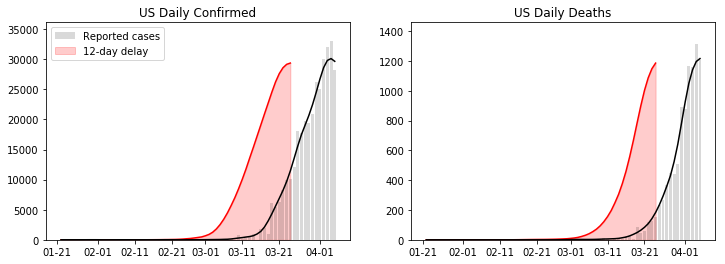

In [17]:
# make plot dataframe
df_pl = df_state.groupby( 'Date').sum() 
df_pl['Date'] = df_pl.index  

fig, ax = plt.subplots(1 ,2,figsize=(full_w[0] ,4))

ax[0] = plot_daily( ax[0] , df_pl['Date'], df_pl['Daily Confirmed'] )
ax[1] = plot_daily( ax[1] , df_pl['Date'], df_pl['Daily Deaths'] )

ax[0].set_title('US Daily Confirmed')
ax[1].set_title('US Daily Deaths')  
ax[0].legend( ax[0].get_legend_handles_labels()[0][::-1] , ax[0].get_legend_handles_labels()[1] [::-1])

# reverse the order
# handles, labels = ax[0].get_legend_handles_labels()
# ax[0].legend(handles[::-1], labels[::-1])


In [18]:
# dir( ax[0].legend() )
ax[0].legend( ax[0].get_legend_handles_labels()[1] [::-1])
 

In [19]:
# sort countries by confirmed cases on last date
bool_last = df_state['Date'] == df_state['Date'].max()
sorted_states = df_state[bool_last].sort_values(by=['Confirmed'], ascending=False )    
sorted_states.head(5)  

,State,Date,Active,Confirmed,Deaths,Recovered,Delta C,Delta D,Measure,Daily Confirmed,Daily Deaths
2474,New York,737520.0,0.0,123160.0,4159.0,0.0,28.0,20.0,NaN,9327.0,594.0
2324,New Jersey,737520.0,0.0,37505.0,917.0,0.0,20.0,16.0,NaN,3381.0,71.0
1724,Michigan,737520.0,0.0,15718.0,617.0,0.0,17.0,13.0,NaN,1493.0,77.0
374,California,737520.0,0.0,15034.0,348.0,0.0,26.0,19.0,NaN,2197.0,59.0
1424,Louisiana,737520.0,0.0,13010.0,477.0,0.0,20.0,17.0,NaN,514.0,68.0


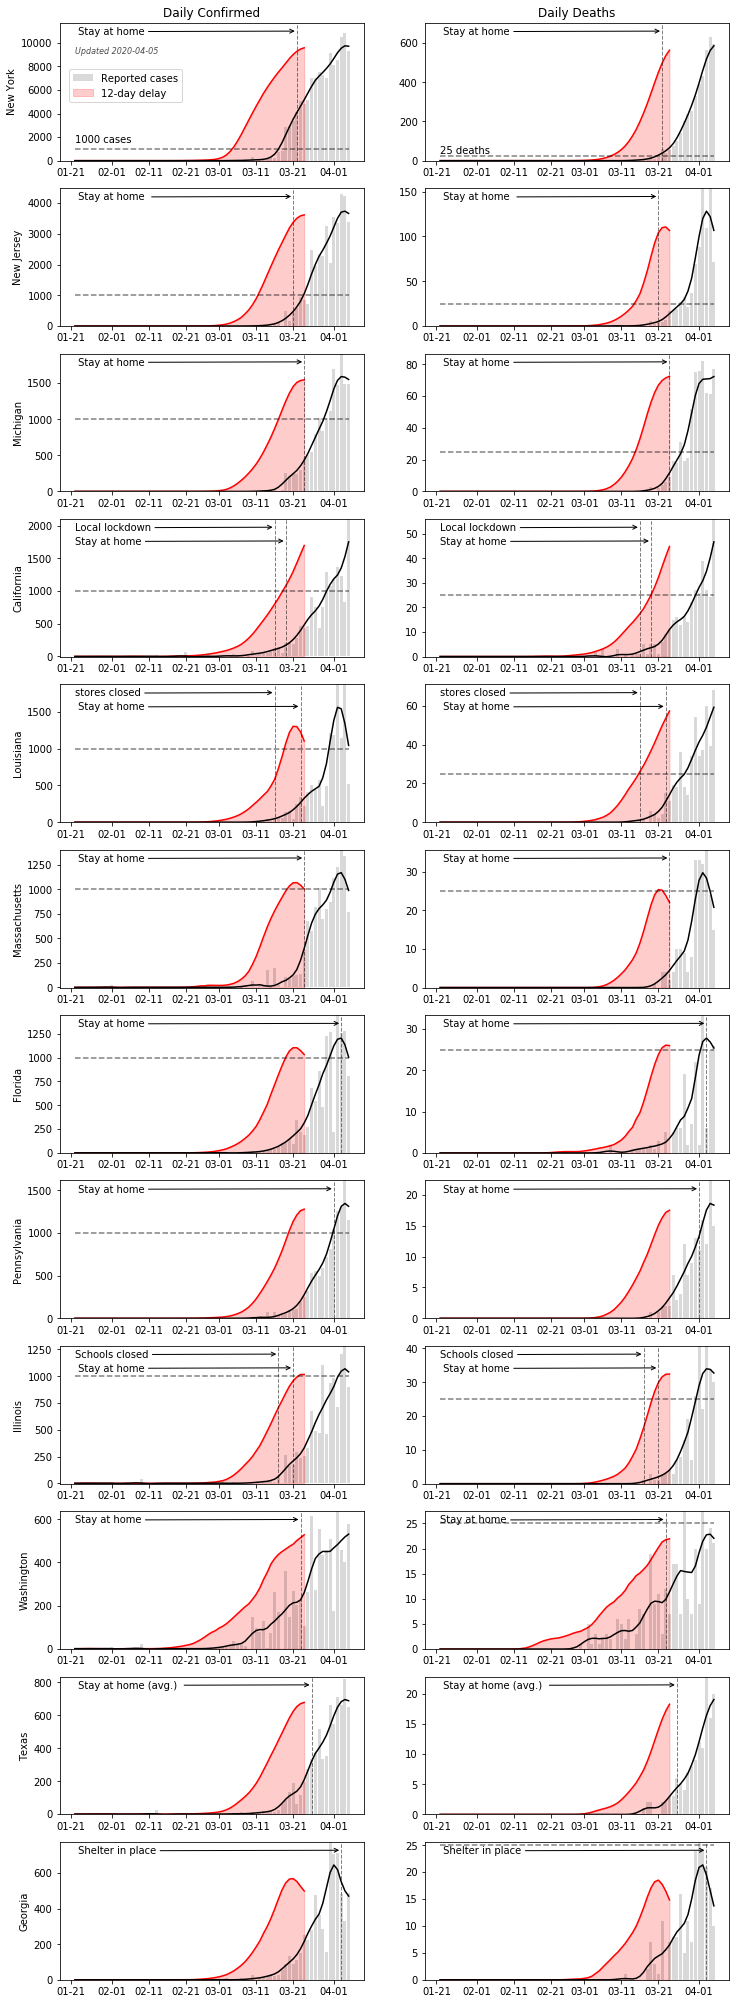

In [20]:
n_state = 12
top_state = sorted_states['State'][:n_state].tolist()

dates = df_pl['Date' ].unique() 
fig, ax = plt.subplots(n_state ,2,figsize=( full_w[0] ,n_state*3))

n_correction = 1

for i,country in enumerate( top_state ):
    df_pl = df_state[ df_state['State'] == country]
    
    bool_measure = df_pl['Measure'].notnull() 
    measures= df_pl.loc[bool_measure,['Measure','Date']] 
     
    plot_daily( ax[i,0] , df_pl['Date'], df_pl['Daily Confirmed'], measures)
    plot_daily( ax[i,1] , df_pl['Date'], df_pl['Daily Deaths'],measures)
 
    # add comparison lines  
    ax[i,0].plot( dates[[0,len(days)-1]], [1000,1000],'--',color='k', alpha = 0.5 )
    ax[i,1].plot( dates[[0,len(days)-1]], [25,25],'--',color='k', alpha = 0.5 ) 
    ax[i,0].set_ylabel( country )
       
ax[0,0].set_title('Daily Confirmed')
ax[0,1].set_title('Daily Deaths') 

# ax[0,0].legend(  bbox_to_anchor=(0.42, .7))  
# # reverse the order
# handles, labels = ax[0,0].get_legend_handles_labels()
# ax[0,0].legend(handles[::-1], labels[::-1])

ax[0,0].legend(  ax[0,0].get_legend_handles_labels()[0][::-1] , 
               ax[0,0].get_legend_handles_labels()[1] [::-1],
               bbox_to_anchor=(0.42, .7))

ax[0,0].annotate('1000 cases',[dates[0],1000*1.5])
ax[0,1].annotate('25 deaths',[dates[0],25*1.5])


ax[0,0].annotate('Updated '+str(  dt.num2date(dates[-1]).date()  ), 
            [dates[0], df_state['Daily Confirmed'].max()*(0.94-0.1)], 
                color=[.3,.3,.3], style='italic',fontsize=8)
#             [dt.date2num( dates[0] ) ,df_country['Daily Confirmed'].max()*(0.94-0.2)], 

# # # # # save fig  -----------------------------------------------------------------------
fig_name= 'covid_states_dailycases'
save_fig = True
if save_fig: 
    plt.savefig('./figs/' + fig_name + '.png',
            format='png', dpi=300,
            transparent=  True,             
            bbox_inches = 'tight', pad_inches = 0,
            )  